### ISSM CA3

In [34]:
import numpy as np
import pandas as pd
import pydot
import IPython
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import time

from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from keras.utils import plot_model

### Dataset attributes
Column 1: Timestamp in seconds  
Column 2: Timestamp in microseconds  
Column 3-15: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S1 (Left Calf)  
Column 16-28: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S2 (Left Thigh)  
Column 29-41: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S3 (Right Calf)  
Column 42-54: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S4 (Right Thigh)  
Column 55-67: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S5 (Back)  
Column 68-80: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S6 (Left Lower Arm)  
Column 81-93: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S7 (Left Upper Arm)  
Column 94-106: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S8 (Right Lower Arm)  
Column 107-119: [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, MagX, MagY, MagZ, Q1, Q2, Q3, Q4] of sensor S9 (Right Upper Arm)  
Column 120: Label (see activity set) [Walking = 1] [Jogging = 2] [Running = 3]

### Run following cells for the following dataset structure:
* df_walk : all 17 subjects + walking + (accel + gyro + quart)  
* df_jog : all 17 subjects + jogging + (accel + gyro + quart)  
* df_run : all 17 subjects + running + (accel + gyro + quart)  
    
Col[0]: Timestamp in seconds  
Col[1]: Timestamp in microseconds  
Col[67-79]: Sensor S6 (without Mag sensor [74 - 76])  
Col[93-105]: Sensor S8 (without Mag sensor [100 - 103])  
Col[119]: Activity Label

In [2]:
data_dir = '..\dataset'
# This method reads all dataset and filter out walking, jogging and running activities
def readcsvDataset(directory):
    files = glob.glob(directory + '\*.csv')
    df_walk = []
    df_jog = []
    df_run = []
    for file in files:
        df_all = pd.read_csv(file, header=None, delim_whitespace=True)
        df_walk.append(df_all[df_all[119] == 1])
        df_jog.append(df_all[df_all[119] == 2])
        df_run.append(df_all[df_all[119] == 3])
    return pd.concat(df_walk, ignore_index=True), pd.concat(df_jog, ignore_index=True), pd.concat(df_run, ignore_index=True)

In [3]:
# This method removes all positional sensors other than left/right lower arm, as well as Magnetic sensors
def removeOtherSensor(df_walk, df_jog, df_run):
    # [2:67] S1 to S5
    # [73:76] Mag sensor for S6
    # [80:93] S7
    # [99:102] Mag sensor for S8
    # [106:119] S9
    idx = np.r_[2:67, 73:76, 80:93, 99,102, 106:119]
    return df_walk.drop(df_walk.columns[idx], axis=1), df_jog.drop(df_jog.columns[idx], axis=1), df_run.drop(df_run.columns[idx], axis=1)

In [4]:
%%time
dfw, dfj, dfr = readcsvDataset(data_dir)

Wall time: 31.9 s


In [5]:
dfwalk, dfjog, dfrun = removeOtherSensor(dfw, dfj, dfr)

In [6]:
standscale = StandardScaler()
dfwalk = standscale.fit_transform(dfwalk)
dfjog = standscale.fit_transform(dfjog)
dfrun = standscale.fit_transform(dfrun)

In [7]:
dfwalk.shape

(45638, 24)

### Run following cells for the following dataset structure:
* df_accel: all 17 subjects + (walk || jog || run) + accel
* df_gyro: all 17 subjects + (walk || jog || run) + gyro
* df_quart: all 17 subjects + (walk || jog || run) + quart

In [8]:
def splitSensor(df):
    # index for time
    idx_time = [0,1]
    # index for activity
    idx_activity = [119]
    # index for accel sensor for S6 and S8
    idx_accel = idx_time + [67, 68, 69, 93, 94, 95] + idx_activity
    # index for gryo sensor for S6 and S8
    idx_gyro = idx_time + [70, 71, 72, 96, 97, 98] + idx_activity
    # index for quart sensor for S6 and S8
    idx_quart = idx_time + [76, 77, 78, 79, 102, 103, 104, 105] + idx_activity
    
    return df[idx_accel], df[idx_gyro], df[idx_quart]

In [9]:
dfaccel, dfgyro, dfquart = splitSensor(dfr)

In [10]:
dfaccel.columns = ['Seconds', 'Microseconds', 'S6_AccX', 'S6_AccY', 'S6_AccZ', 'S8_AccX', 'S8_AccY', 'S8_AccZ', 'Activity']
dfgyro.columns = ['Seconds', 'Microseconds', 'S6_GyrX', 'S6_GyrY', 'S6_GyrZ', 'S8_GyrX', 'S8_GyrY', 'S8_GyrZ', 'Activity']
dfquart.columns = ['Seconds', 'Microseconds', 'S6_Q1', 'S6_Q2', 'S6_Q3', 'S6_Q4', 'S8_Q1', 'S8_Q2', 'S8_Q3', 'S8_Q4', 'Activity']

In [11]:
dfaccel = dfaccel.drop(['Seconds', 'Microseconds', 'Activity'], axis=1)
dfaccel.head()

,S6_AccX,S6_AccY,S6_AccZ,S8_AccX,S8_AccY,S8_AccZ
0,1.4122,-2.41950,14.6970,-3.8459,-5.679600,-4.0406
1,7.0918,-2.31050,18.3930,-12.1090,-2.293900,-6.4204
2,8.6302,-0.81221,15.4420,-22.5160,-1.304600,-4.8783
3,7.5291,1.03300,10.0310,-17.6310,0.057412,-1.6752
4,7.7501,2.09880,6.9139,-14.1530,-0.511720,-1.1493


In [12]:
dfaccel.shape

(40142, 6)

In [13]:
dfgyro = dfgyro.drop(['Seconds', 'Microseconds', 'Activity'], axis=1)
dfgyro.head()

,S6_GyrX,S6_GyrY,S6_GyrZ,S8_GyrX,S8_GyrY,S8_GyrZ
0,-1.63200,-0.55933,0.941290,0.26695,1.5552,0.41222
1,-0.68447,1.45270,0.519170,1.29020,2.7345,1.06410
2,-1.31230,3.91880,0.030051,1.61850,2.4691,0.93687
3,-1.23930,5.87110,0.097996,1.14530,3.5412,0.56630
4,-1.15990,6.80680,0.307600,0.65851,3.8733,-0.14329


In [14]:
dfgyro.shape

(40142, 6)

In [15]:
dfquart = dfquart.drop(['Seconds', 'Microseconds', 'Activity'], axis=1)
dfquart.head()

,S6_Q1,S6_Q2,S6_Q3,S6_Q4,S8_Q1,S8_Q2,S8_Q3,S8_Q4
0,-0.13994,0.17305,0.022179,-0.97467,-0.72138,0.15473,-0.65619,-0.15837
1,-0.13406,0.18831,0.025613,-0.97258,-0.70337,0.14305,-0.67923,-0.15311
2,-0.13217,0.22793,0.033093,-0.96410,-0.68718,0.12908,-0.70003,-0.14520
3,-0.13012,0.28571,0.036735,-0.94873,-0.66257,0.12266,-0.72622,-0.13621
4,-0.12607,0.35101,0.037964,-0.92707,-0.63498,0.12456,-0.75198,-0.12572


In [16]:
dfquart.shape

(40142, 8)

In [17]:
standscale = StandardScaler()
dfaccel = standscale.fit_transform(dfaccel)
dfgyro = standscale.fit_transform(dfgyro)
dfquart = standscale.fit_transform(dfquart)

In [18]:
train_size = np.int(len(dfaccel) * 0.8)
train_accel, test_accel = dfaccel[:train_size], dfaccel[train_size:]
train_gyro, test_gyro = dfgyro[:train_size], dfgyro[train_size:]
train_quart, test_quart = dfquart[:train_size], dfquart[train_size:]

In [19]:
test_accel.shape

(8029, 6)

In [20]:
seed = 42
np.random.seed(seed)

In [21]:
# Config
encoder_dimension = 42
EPOCH = 20
BATCH_SIZE = 24

In [37]:
def build_model(train_accel, train_gyro, train_quart):
    # Input dimension
    accel_dim = train_accel.shape[1]
    gyro_dim = train_gyro.shape[1]
    quart_dim = train_quart.shape[1]
    # All input
    input_accel = Input(shape=(accel_dim,), name='Input_Accel')
    input_gyro = Input(shape=(gyro_dim,), name='Input_Gyro')
    input_quart = Input(shape=(quart_dim,), name='Input_Quart')
    # Autoencoder branch for Accel
    accel_encoder = Dense(50, activation='relu', name='Encoder1_Accel')(input_accel)
    accel_encoder = Dense(25, activation='relu', name='Encoder2_Accel')(accel_encoder)
    # Autoencoder branch for Gyro
    gyro_encoder = Dense(50, activation='relu', name='Encoder1_Gyro')(input_gyro)
    gyro_encoder = Dense(25, activation='relu', name='Encoder2_Gyro')(gyro_encoder)
    # Autoencoder branch for Quart
    quart_encoder = Dense(50, activation='relu', name='Encoder1_Quart')(input_quart)
    quart_encoder = Dense(25, activation='relu', name='Encoder2_Quart')(quart_encoder)
    # Shared layer
    shared_input = Concatenate(name='Concatenate')([accel_encoder, gyro_encoder, quart_encoder])
    decoder = Dense(5, activation='relu', name='Shared_Hidden_Layer')(shared_input)
    decoder = Dense(25, activation='relu', name='Decoder1')(decoder)
    decoder = Dense(50, activation='relu', name='Decoder2')(decoder)
    decoder = Dense(6, activation='relu', name='Output')(decoder)
    model = Model(inputs=([input_accel, input_gyro, input_quart]), outputs=decoder)
    return model

In [38]:
model = build_model(train_accel, train_gyro, train_quart)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Accel (InputLayer)        (None, 6)            0                                            
__________________________________________________________________________________________________
Input_Gyro (InputLayer)         (None, 6)            0                                            
__________________________________________________________________________________________________
Input_Quart (InputLayer)        (None, 8)            0                                            
__________________________________________________________________________________________________
Encoder1_Accel (Dense)          (None, 50)           350         Input_Accel[0][0]                
__________________________________________________________________________________________________
Encoder1_G

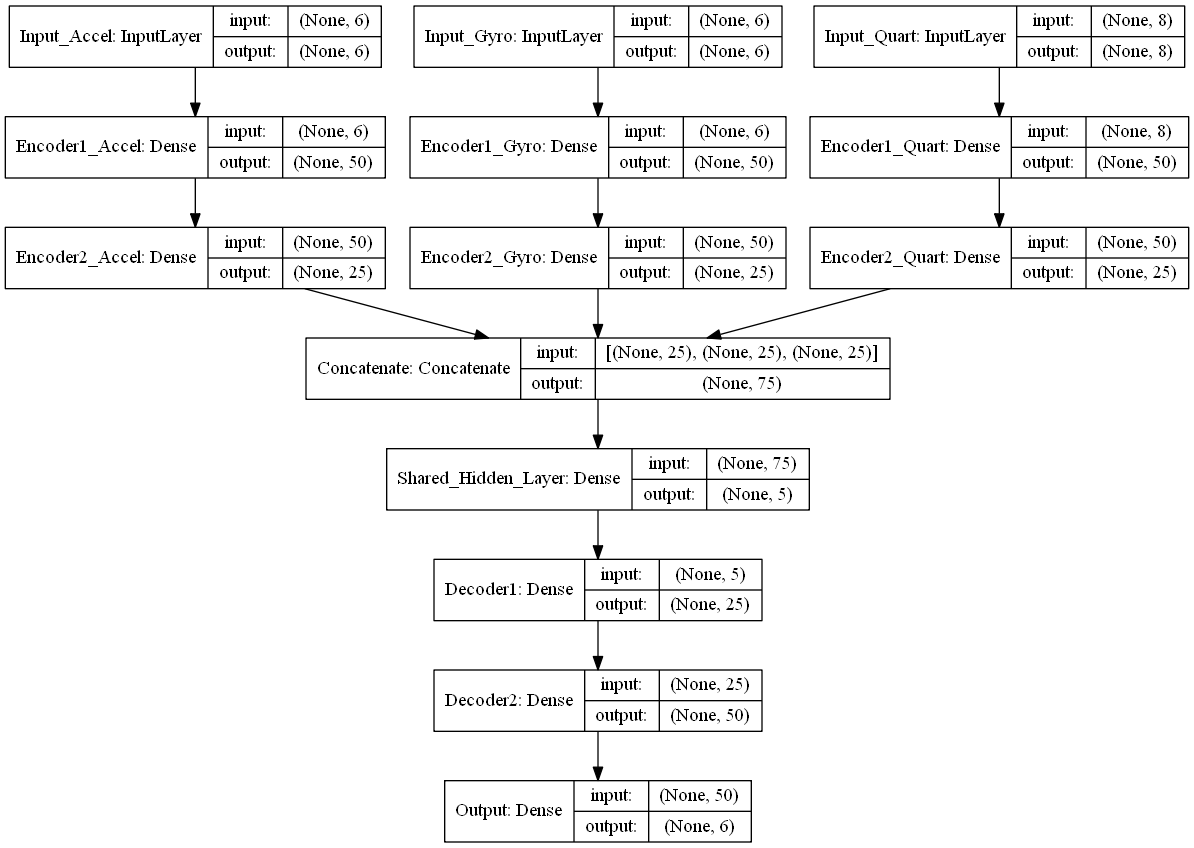

In [39]:
plot_model(model, 
           to_file='model.png', 
           show_shapes=True,
           show_layer_names=True)
IPython.display.Image('model.png')

In [40]:
model.compile(optimizer='adam', metrics=['accuracy'], loss=['mean_squared_logarithmic_error'])

In [41]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)
]

In [42]:
%%time
history = model.fit([train_accel, train_gyro, train_quart], train_accel, 
                    validation_split=0.1, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, callbacks=callbacks)

Train on 28901 samples, validate on 3212 samples
Epoch 1/20
28901/28901 [==============================] - 8s 287us/step - loss: 0.0235 - acc: 0.7944 - val_loss: 0.0021 - val_acc: 0.9580
Epoch 2/20
28901/28901 [==============================] - 8s 261us/step - loss: 0.0045 - acc: 0.9221 - val_loss: 0.0014 - val_acc: 0.9710
Epoch 3/20
28901/28901 [==============================] - 8s 260us/step - loss: 0.0030 - acc: 0.9396 - val_loss: 0.0010 - val_acc: 0.9648
Epoch 4/20
28901/28901 [==============================] - 7s 259us/step - loss: 0.0024 - acc: 0.9455 - val_loss: 9.6940e-04 - val_acc: 0.9751
Epoch 5/20
28901/28901 [==============================] - 7s 259us/step - loss: 0.0020 - acc: 0.9522 - val_loss: 7.5130e-04 - val_acc: 0.9776
Epoch 6/20
28901/28901 [==============================] - 8s 260us/step - loss: 0.0018 - acc: 0.9546 - val_loss: 8.0935e-04 - val_acc: 0.9738
Epoch 7/20
28901/28901 [==============================] - 8s 261us/step - loss: 0.0017 - acc: 0.9561 - val_loss

In [43]:
test_predict = model.predict([test_accel, test_gyro, test_quart])
score, acc = model.evaluate([test_accel, test_gyro, test_quart], test_accel, batch_size=32)
print(f'Test Score: {score}')
print(f'Test Acc: {acc}')

8029/8029 [==============================] - 0s 48us/step
Test Score: 0.004543455947743935
Test Acc: 0.9404658113667403


In [44]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


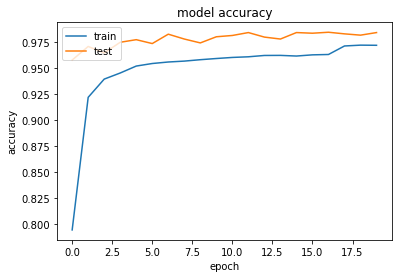

In [45]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

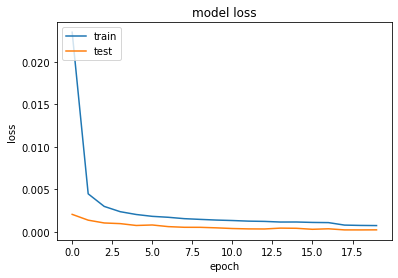

In [46]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
threshold = 6
dist = np.linalg.norm(test_accel - test_predict, axis=1)
print(acc)

0.9404658113667403


In [33]:
if (dist > threshold):
    print('Anomaly')
else:
    print('Normal')    

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()